In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure Visualization Defaults
%matplotlib inline

In [24]:
train = pd.read_csv('data/training_set_VU_DM.csv')

In [2]:
train = pd.read_csv('data/training_set_VU_DM.csv',nrows=1000)
test  = pd.read_csv('data/test_set_VU_DM.csv')

Analyse competitor attributes. There exist three different types of attributes.
- comp-rate           : +1 if Expedia has a lower price than competitor for the hotel; 0 if the same; -1 if Expedia’s price is higher than competitor; null signifies there is no competitive data
- comp_inv            : +1 if competitor does not have availability in the hotel; 0 if both Expedia and competitor have availability; null signifies there is no competitive data
- comp-rate-perc-diff : The absolute percentage difference (if one exists) between Expedia and competitor’s price (Expedia’s price the denominator); null signifies there is no competitive data

why are the number of missing values larger for the comp_rate_percent_diff than for the comp_rate attribute? What is the degree of overlap between these sets? If these sets are complementary we might be able to impute one using the other.

Is it the case that the comp values are more likely to exist for instances where click_bool or booking_bool are true?

## Analysis of competitor variables

In [4]:
# compute the average number of missing values for each of the three attributes
# averaged over the three competitors
s = []
for i in range(1,9):
    s.append(sum(test['comp'+str(i)+'_rate'].isna()))
print(s)
a = np.average(s)
print('Average comp_rate (across competitors):',a/test.shape[0])
print('\n')
s = []
for i in range(1,9):
    s.append(sum(test['comp'+str(i)+'_inv'].isna()))
print(s)
a = np.average(s)
print('Average comp_inv  (across competitors):',a/test.shape[0])
print('\n')
s = []
for i in range(1,9):
    s.append(sum(test['comp'+str(i)+'_rate_percent_diff'].isna()))
print(s)
a = np.average(s)
print('Average comp_diff (across competitors):',a/test.shape[0])

[4843307, 2943222, 3434198, 4646462, 2737262, 4716853, 4643454, 3056794]
Average comp_rate (across competitors): 0.7819219415778769


[4834309, 2837914, 3317952, 4610375, 2598370, 4696014, 4602430, 2986298]
Average comp_inv  (across competitors): 0.7683640127819441


[4868715, 4405574, 4487973, 4826056, 4119276, 4862045, 4819860, 4348206]
Average comp_diff (across competitors): 0.9260019493130219


Proportion of total number of null vals    :  0.34836705965478587
Proportion of total number of non-null vals:  0.6516329403452141


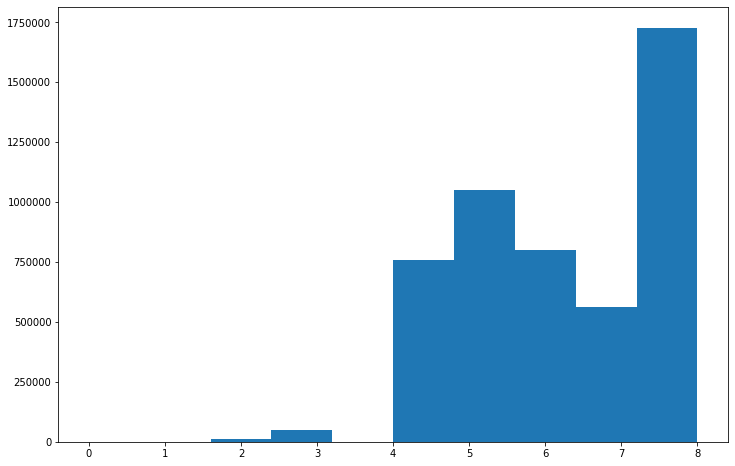

[0 1 2 3 4 5 6 7 8]
[      1      11   10243   48312  758551 1049874  800408  564167 1727616]


In [21]:
# check the number of missing values for the rate variable if we collapse the variable, across competitors
n_comp = 8
for i in range(1,n_comp+1):
    if i == 1:
        rate_na_comp = test['comp'+str(i)+'_rate'].isna().astype(int)
    else:
        rate_na_comp += test['comp'+str(i)+'_rate'].isna().astype(int)
total_na_comp = sum(rate_na_comp==n_comp)
print('Proportion of total number of null vals    : ',total_na_comp/test.shape[0])
print('Proportion of total number of non-null vals: ',1-(total_na_comp/test.shape[0]))
unique_elements, counts_elements = np.unique(rate_not_na_comp, return_counts=True)
plt.hist(rate_not_na_comp)
plt.show()
print(unique_elements)
print(counts_elements)

Proportion of total number of null vals    :  0.32620937763337227
Proportion of total number of non-null vals:  0.6737906223666277


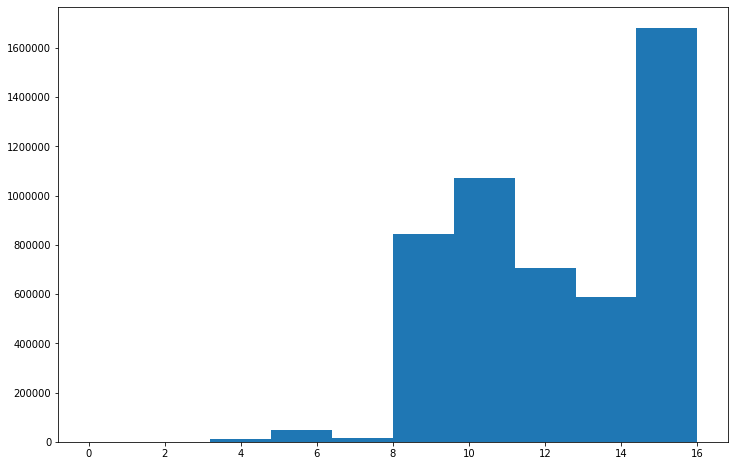

[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[      1      11       4   10240    2727   46033   14041  746283   95836
  966813  102824  706689   83067  502963   63919 1617732]


In [23]:
# now check the number of missing values if we collapse all three competitor variables, across competitors
n_comp = 8
for i in range(1,n_comp+1):
    if i == 1:
        na_comp = test['comp'+str(i)+'_rate'].isna().astype(int)
        na_comp += test['comp'+str(i)+'_inv'].isna().astype(int)
#         na_comp += test['comp'+str(i)+'_rate_percent_diff'].isna().astype(int)
    else:
        na_comp += test['comp'+str(i)+'_rate'].isna().astype(int)
        na_comp += test['comp'+str(i)+'_inv'].isna().astype(int)
#         na_comp += test['comp'+str(i)+'_rate_percent_diff'].isna().astype(int)
total_na_comp = sum(na_comp==(2*n_comp))
print('Proportion of total number of null vals    : ',total_na_comp/test.shape[0])
print('Proportion of total number of non-null vals: ',1-(total_na_comp/test.shape[0]))
unique_elements, counts_elements = np.unique(na_comp, return_counts=True)
plt.hist(na_comp)
plt.show()
print(unique_elements)
print(counts_elements)

## Feature engineering (comp_cheapest)

In [28]:
# engineer new boolean attribute called comp_cheapest, which is 1 if Expedia has the lowest rate of all competitors
# and 0 if there is at least one competitor with a lower rate
n_comp = 8
for i in range(1,n_comp+1):
    if i == 1:
        rate_na_comp = test['comp'+str(i)+'_rate'].isna().astype(int)
        temp_cheapest = (test['comp'+str(i)+'_rate']==-1).astype(int)
    else:
        rate_na_comp += test['comp'+str(i)+'_rate'].isna().astype(int)
        temp_cheapest += (test['comp'+str(i)+'_rate']==-1).astype(int)
comp_cheapest_test = temp_cheapest == 0
u, c = np.unique(comp_cheapest[rate_na_comp<8], return_counts=True)

# next we impute the null values by sampling from the empirical distribution of comp_cheapest
comp_cheapest_test[rate_na_comp==8] = np.random.choice(u, np.sum(rate_na_comp==8),p=c/np.sum(c))
print(u)
print(c)
print('Proportion of cheaper hotels (null total): ',c[1]/test.shape[0])
print('Proportion of cheaper hotels (non-null total): ',c[1]/(c[0]+c[1]))
print('Proportion of null values: ',1-((c[0]+c[1])/test.shape[0]))

[False  True]
[ 585371 2646196]
Proportion of cheaper hotels (null total):  0.5335951506528394
Proportion of cheaper hotels (non-null total):  0.8188584671151797
Proportion of null values:  0.34836705965478587


In [26]:
# repeat this proces for the training set
n_comp = 8
for i in range(1,n_comp+1):
    if i == 1:
        rate_na_comp = train['comp'+str(i)+'_rate'].isna().astype(int)
        temp_cheapest = (train['comp'+str(i)+'_rate']==-1).astype(int)
    else:
        rate_na_comp += train['comp'+str(i)+'_rate'].isna().astype(int)
        temp_cheapest += (train['comp'+str(i)+'_rate']==-1).astype(int)
comp_cheapest_train = temp_cheapest == 0
u, c = np.unique(comp_cheapest_train[rate_na_comp<8], return_counts=True)

# next we impute the null values by sampling from the empirical distribution of comp_cheapest
comp_cheapest_train[rate_na_comp==8] = np.random.choice(u, np.sum(rate_na_comp==8),p=c/np.sum(c))

Save the novel features

In [30]:
# save the novel feature to a csv file
df = pd.DataFrame()
df['comp_cheapest'] = comp_cheapest_train
df.to_csv('test_set_comp_cheapest.csv',index=False)
df.info()

df = pd.DataFrame()
df['comp_cheapest'] = comp_cheapest_test
df.info()
df.to_csv('train_set_comp_cheapest.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4959183 entries, 0 to 4959182
Data columns (total 1 columns):
 #   Column         Dtype
---  ------         -----
 0   comp_cheapest  bool 
dtypes: bool(1)
memory usage: 4.7 MB


In [13]:
# show the proportion of cheaper hotels after imputation
u, c = np.unique(comp_cheapest, return_counts=True)
print(u)
print(c)
print('Proportion of cheaper hotels (null total): ',c[1]/test.shape[0])
print('Proportion of cheaper hotels (non-null total): ',c[1]/(c[0]+c[1]))
print('Proportion of null values: ',1-((c[0]+c[1])/test.shape[0]))

[False  True]
[ 898673 4060510]
Proportion of cheaper hotels (null total):  0.8187860782713604
Proportion of cheaper hotels (non-null total):  0.8187860782713604
Proportion of null values:  0.0
